# dSA resolution studies

This notebook describes studies of dSA resolution, in pT, eta, phi, and dR, compared to generalTracks. The resolution is measured by comparing reconstructed quantities with generated quantities, so it runs only on MC samples. dSA resolution is well-known to be quite a bit worse than other objects due to the relaxing of several constraints in the reconstruction. We also look at the discrepancy between MC and data in some of the quantities used to define the displaced ID, which has also been studied before.

## Check spark

First of all make sure spark object is created.

In [2]:
spark

## Load system modules

In [3]:
import os
import sys
import matplotlib as mpl
import matplotlib.pyplot as plt

if 'notebooks' in os.getcwd():
    os.chdir('..')

## Load package modules

Including the config to be used throughout the notebook.

In [19]:
from flattener import *
from registry import registry
from config import Configuration
my_config = Configuration('configs/displacedID_Z.json')
# my_config = Configuration('configs/displacedID_JPsi.json')

## Recreate the dataframe

Let's recreate the dataframe and use it interactively to plot efficiencies.

In [8]:
def get_df(resonance,era,subEra):

    useParquet = True
    
    if useParquet:
        fnames = list(registry.parquet(
            particle, probe, resonance, era, subEra))
        print(fnames)
    else:
        fnames = registry.root(particle, probe, resonance, era, subEra)
        fnames = ['root://eoscms.cern.ch/'+f for f in fnames]

    doGen = subEra in ['DY_madgraph', 'JPsi_pythia8']

    # default numerator/denominator defintions
    definitions = my_config.definitions()

    # for when we use root files instead of parquet
    # treename = 'tpTree/fitter_tree'
    treename = 'muon/Events'
    
    # get the dataframe
    if useParquet:
        print('Loading parquet files:', fnames)
        if isinstance(fnames, list):
            baseDF = spark.read.parquet(*fnames)
        else:
            baseDF = spark.read.parquet(fnames)
    else:
        treename = registry.treename(particle, probe, resonance, era, subEra)
        baseDF = spark.read.format("root")\
                      .option('tree', treename)\
                      .load(fnames)
        
    defDF = baseDF
    for d in definitions:
        defDF = defDF.withColumn(d, F.expr(definitions[d]))

    # select tags
    tagsDF = defDF.filter(my_config.selection())        
        
    # build the weights (pileup for MC)
    weightedDF = get_weighted_dataframe(tagsDF, doGen, resonance, era, subEra)
    
    # create the binning structure
    fitVariable = my_config.fitVariable()
    binningSet = set([fitVariable])
    if doGen:
        fitVariableGen = my_config.fitVariableGen()
        binningSet = binningSet.union(set([fitVariableGen]))
    binVariables = my_config.binVariables()
    for bvs in binVariables:
        binningSet = binningSet.union(set(bvs))

    binning = my_config.binning()
    variables = my_config.variables()
    binnedDF = weightedDF
    for bName in binningSet:
        binnedDF = get_binned_dataframe(
            binnedDF, bName+"Bin",
            variables[bName]['variable'],
            binning[bName])

    return binnedDF

Pick which resonance to study.

In [20]:
particle = 'muon'
probe = 'dSAMuons'
resonance = 'Z'
# resonance = 'JPsi'
era = 'Run2018'
subEras = ['Run2018A', 'DY_madgraph']
# subEras = ['Run2018A', 'JPsi_pythia8']
sim_alias = 'DY_madgraph'
# sim_alias = 'JPsi_pythia8'

dfs = {subEra: get_df(resonance,era,subEra) for subEra in subEras}
# Create derived sets from original df
dfs_dsa = {subera: dfs[subera].filter('probe_isdSA==1') for subera in subEras}
dfs_gen = {subera: dfs_dsa[subera].filter(
    'tag_isMatchedGen==1 and probe_isMatchedGen==1 and genmu1_pt > 0 and genmu2_pt > 0') for subera in subEras}

['/user/asterenb/parquet/muon/Z/EOY_ReReco/Run2018A/tnp.parquet']
Loading parquet files: ['/user/asterenb/parquet/muon/Z/EOY_ReReco/Run2018A/tnp.parquet']
['/user/asterenb/parquet/muon/Z/EOY_ReReco_fixGenMatch/DY_madgraph_2018/tnp.parquet']
Loading parquet files: ['/user/asterenb/parquet/muon/Z/EOY_ReReco_fixGenMatch/DY_madgraph_2018/tnp.parquet']


## Plot quantities

Example plotting several relevant distributions. Some of these quantities were defined in 'definitions' section of config file (e.g. 'displacedID_Z.json'), while others were already available as branches in the ntuple.

In [9]:
def plot(dfs, plotVar, edges, xlabel='', additional_text='', high_quality=False):
    mpl.rcParams['figure.dpi'] = 300 if high_quality else 80
    
    sim = None
    if 'DY_madgraph' in dfs.keys():
        sim = 'DY_madgraph'
    elif 'JPsi_pythia8' in dfs.keys():
        sim = 'JPsi_pythia8'
        
    data = None
    if 'Run2018A' in dfs.keys():
        data = 'Run2018A'

    def reduce_df(df):
        df = get_binned_dataframe(df, 'tmpBin', plotVar, edges)
        df = df.groupBy('tmpBin').agg({'weight': 'sum', 'weight2': 'sum'})
        df = df.withColumnRenamed('sum(weight)','sumw')
        df = df.withColumnRenamed('sum(weight2)','sumw2')
        df = df.toPandas().set_index('tmpBin').sort_index()
        return df
    
    if data is not None:
        df = reduce_df(dfs['Run2018A'])
    if sim is not None:
        df_mc = reduce_df(dfs[sim])
    
    bx = edges
    if data is not None:
        y = pd.Series(np.zeros(len(edges)+1))
        yerr = pd.Series(np.zeros(len(edges)+1))
    if sim is not None:
        y_mc = pd.Series(np.zeros(len(edges)+1))
        yerr_mc = pd.Series(np.zeros(len(edges)+1))
    
    x = [(bx[i]+bx[i+1])/2 for i in range(len(bx)-1)]
    xerr = [abs(x[i]-bx[i]) for i in range(len(bx)-1)]
    
    if data is not None:
        y[df.index] = df['sumw']
        integral = sum(y)
        y = y/integral
        y = y[1:len(bx)]
        yerr[df.index] = np.sqrt(df['sumw2']) 
        yerr = yerr / integral
        yerr = yerr[1:len(bx)]
    
    if sim is not None:
        y_mc[df_mc.index] = df_mc['sumw']
        integral_mc = sum(y_mc)
        y_mc = y_mc / integral_mc
        y_mc = y_mc[1:len(bx)]
        yerr_mc[df_mc.index] = np.sqrt(df_mc['sumw2']) 
        yerr_mc = yerr_mc / integral_mc
        yerr_mc = yerr_mc[1:len(bx)]
    
    if data is not None:
        plt.errorbar(x,y,xerr=xerr,yerr=yerr,fmt='.k')
#         plt.yscale('log')
    if sim is not None:
        plt.errorbar(x,y_mc,xerr=xerr,yerr=yerr_mc,fmt='.b')
        
    if sim is not None and data is not None:
        plt.legend(['Data','Simulation'],frameon=False)
    elif data is not None:
        plt.legend(['Data'],frameon=False)
    elif sim is not None:
        plt.legend(['Simulation'],frameon=False)
        
    plt.ylabel('Unit normalized')
    plt.xlabel(xlabel)
    if additional_text: plt.text(bx[0],0.95*max([max(y),max(y_mc if sim is not None else 0.0)]), additional_text)
    plt.show()

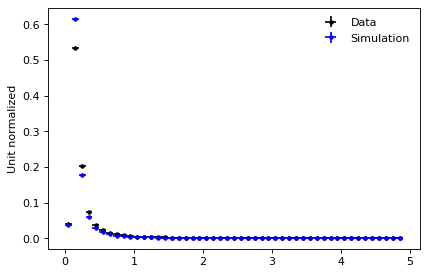

In [10]:
plot(dfs_dsa, 'probe_dsa_pterr', np.array(np.arange(0,5,.1)))

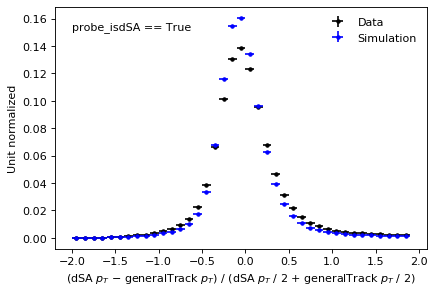

In [12]:
plot(dfs_dsa, 'diff_dsa_trk_pt', np.array(np.arange(-2, 2, 0.1)), 
     xlabel='(dSA $p_{T}$ $-$ generalTrack $p_{T}$) / (dSA $p_{T}$ / 2 $+$ generalTrack $p_{T}$ / 2)', 
     additional_text='probe_isdSA == True', high_quality=False)

plot(dfs_dsa, 'diff_dsa_trk_eta', np.array(np.arange(-0.05, 0.055, 0.0025)), 
     xlabel='(dSA $\eta$ $-$ generalTrack $\eta$) / (dSA $\eta$ / 2 $+$ generalTrack $\eta$ / 2)',
     additional_text='probe_isdSA == True', high_quality=False)

plot(dfs_dsa, 'diff_dsa_trk_phi', np.array(np.arange(-0.1, 0.11, 0.005)), 
     xlabel='(dSA $\phi$ $-$ generalTrack $\phi$) / (dSA $\phi$ / 2 $+$ generalTrack $\phi$ / 2)', 
     additional_text='probe_isdSA == True', high_quality=False)

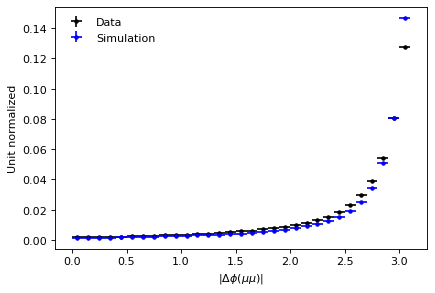

In [15]:
plot(dfs_dsa, 'pair_reduced_dphi', np.array(np.arange(0, 3.2, .1)), 
     xlabel=r'$|\Delta\phi(\mu\mu)|$', high_quality=False)

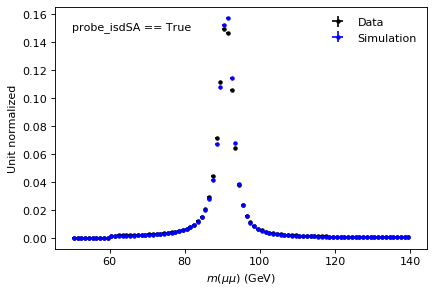

In [16]:
# plot(dfs_pt20, 'pair_mass', np.array(range(40,161,1)), xlabel=r'$m(\mu\mu)$ (GeV)', additional_text=r'$p_{T} > 20$ (GeV)')
# plot(dfs_dsa, 'pair_mass', np.array(np.arange(2.8,3.4,0.01)), xlabel=r'$m(\mu\mu)$ (GeV)', additional_text='probe_isdSA == True', high_quality=True)
plot(dfs_dsa, 'pair_mass', np.array(np.arange(50,141,1)), xlabel=r'$m(\mu\mu)$ (GeV)', 
     additional_text='probe_isdSA == True', high_quality=False)
# plot(dfs, 'pair_mass', np.array(range(1,10,1)), xlabel=r'$m(\mu\mu)$ (GeV)', additional_text=r'$p_{T} > 20$ (GeV)')

## Reco vs. truth resolution studies

Here we study the pT, eta, and phi resolutions of reconstructed muons relative to gen muons. We want to compare the resolution between generalTracks and dSA tracks, to confirm that dSA resolutions are indeed worse and therefore it is safer to use the generalTrack quantities in the derivation of the nominal efficiencies and scale factors.

Define plotting functions to compare reconstructed and truth information.

In [11]:
def plot_MC_res(dfs, plotVar, edges, xlabel='', additional_text='', 
                high_quality=False, fig=None, ax=None, style='.b', label='Simulation'):

    mpl.rcParams['figure.dpi'] = 300 if high_quality else 80
    
    sim = None
    if 'DY_madgraph' in dfs.keys():
        sim = 'DY_madgraph'
    elif 'JPsi_pythia8' in dfs.keys():
        sim = 'JPsi_pythia8'

    def reduce_df(df):
        df = get_binned_dataframe(df, 'tmpBin', plotVar, edges)
        df = df.groupBy('tmpBin').agg({'weight': 'sum', 'weight2': 'sum'})
        df = df.withColumnRenamed('sum(weight)','sumw')
        df = df.withColumnRenamed('sum(weight2)','sumw2')
        df = df.toPandas().set_index('tmpBin').sort_index()
        return df
    
    if sim is not None:
        df_mc = reduce_df(dfs[sim])
    
    bx = edges
    if sim is not None:
        y_mc = pd.Series(np.zeros(len(edges)+1))
        yerr_mc = pd.Series(np.zeros(len(edges)+1))
    
    x = [(bx[i]+bx[i+1])/2 for i in range(len(bx)-1)]
    xerr = [abs(x[i]-bx[i]) for i in range(len(bx)-1)]
    
    if sim is not None:
        y_mc[df_mc.index] = df_mc['sumw']
        integral_mc = sum(y_mc)
        y_mc = y_mc / integral_mc
        y_mc = y_mc[1:len(bx)]
        yerr_mc[df_mc.index] = np.sqrt(df_mc['sumw2']) 
        yerr_mc = yerr_mc / integral_mc
        yerr_mc = yerr_mc[1:len(bx)]
    
    if fig is None:
        fig, ax = plt.subplots(1)
    
    if sim is not None:
        ax.errorbar(x,y_mc,xerr=xerr,yerr=yerr_mc,fmt=style, label=label)
        
#     fig.legend(frameon=False)
#     plt.ylabel('Unit normalized')
#     plt.xlabel(xlabel)
#     if additional_text: fig.text(bx[0],0.95*max([max(y),max(y_mc if sim is not None else 0.0)]), additional_text)

    return fig, ax


In [12]:
def plot_MC_res_vs_eta(dfs, edges, xlabel='', additional_text='', 
                high_quality=False, fig=None, ax=None, style='.b'):

    mpl.rcParams['figure.dpi'] = 300 if high_quality else 80
    
    sim = None
    if 'DY_madgraph' in dfs.keys():
        sim = 'DY_madgraph'
    elif 'JPsi_pythia8' in dfs.keys():
        sim = 'JPsi_pythia8'

    def reduce_df(df):
        df = df.groupBy('etaBin', 'tmpBin').agg({'weight':'sum', 'weight2':'sum'})
        df = df.withColumnRenamed('sum(weight)','sumw')
        df = df.withColumnRenamed('sum(weight2)','sumw2')
        df = df.toPandas().set_index(['etaBin','tmpBin']).sort_index()
        return df
    
    if sim is not None:
        df_dsares = get_binned_dataframe(dfs[sim], 'tmpBin', 'diff_dsa_gen_pt', edges)
        df_dsares = reduce_df(df_dsares)
        df_trkres = get_binned_dataframe(dfs[sim], 'tmpBin', 'diff_trk_gen_pt', edges)
        df_trkres = reduce_df(df_trkres)
        
    bz = my_config.binning()['eta']
    
    bx = edges
    
    biases_dsa, biases_err_dsa = [], []
    stddevs_dsa = []
    biases_trk, biases_err_trk = [], []
    stddevs_trk = []
    
    xlabel=r'(reco $p_{T}$ - true $p_{T}$) / true $p_{T}$'
    fig, axs = plt.subplots(4, 4, figsize=(15, 15))
    axs = axs.ravel()
    
    for etabin, eta in enumerate(bz):
        if etabin == 0: continue
        idx = pd.IndexSlice
        df_dsares_eta = df_dsares.loc[idx[etabin:etabin]]
        df_trkres_eta = df_trkres.loc[idx[etabin:etabin]]
        
        def calc_stats(x, y):
            tmp_sum, tmp_prod = 0, 0
            for x_i, y_i in zip(x, y):
                tmp_sum += y_i
                tmp_prod += x_i*y_i
            hist_mean = tmp_prod/tmp_sum
            sqsum = 0
            for x_i, y_i in zip(x, y):
                dx = x_i - hist_mean
                sqsum += y_i*dx*dx
            stdv = np.sqrt(sqsum/tmp_sum)
            return (hist_mean, stdv)            

        x = [(bx[i]+bx[i+1])/2 for i in range(len(bx)-1)]
        xerr = [abs(x[i]-bx[i]) for i in range(len(bx)-1)]

        if sim is not None:
            y_mc = pd.Series(np.zeros(len(bx)+1))
            yerr_mc = pd.Series(np.zeros(len(bx)+1))
            
            y_mc[df_dsares_eta.index.get_level_values('tmpBin')] = df_dsares_eta['sumw']
            integral_mc = sum(y_mc)
            y_mc = y_mc / integral_mc
            y_mc = y_mc[1:len(bx)]
            yerr_mc[df_dsares_eta.index.get_level_values('tmpBin')] = np.sqrt(df_dsares_eta['sumw2']) 
            integral_mc = sum(yerr_mc)
            yerr_mc = yerr_mc / integral_mc
            yerr_mc = yerr_mc[1:len(bx)]
            axs[etabin-1].errorbar(x,y_mc,xerr=xerr,yerr=yerr_mc,fmt='.b', label='dSA')
            
            hist_mean, hist_stddev = calc_stats(x, y_mc)
            biases_dsa.append(hist_mean)
            # biases_err.append(hist_mean_err)
            stddevs_dsa.append(hist_stddev)
            
            y_mc = pd.Series(np.zeros(len(bx)+1))
            yerr_mc = pd.Series(np.zeros(len(bx)+1))
            
            y_mc[df_trkres_eta.index.get_level_values('tmpBin')] = df_trkres_eta['sumw']
            integral_mc = sum(y_mc)
            y_mc = y_mc / integral_mc
            y_mc = y_mc[1:len(bx)]
            yerr_mc[df_trkres_eta.index.get_level_values('tmpBin')] = np.sqrt(df_trkres_eta['sumw2']) 
            integral_mc = sum(yerr_mc)
            yerr_mc = yerr_mc / integral_mc
            yerr_mc = yerr_mc[1:len(bx)]
            axs[etabin-1].errorbar(x,y_mc,xerr=xerr,yerr=yerr_mc,fmt='.r', label='genTrack')
            axs[etabin-1].set_xlabel(xlabel)
            axs[etabin-1].set_ylabel('A. U.')
            additional_text = r'${low} < \eta < {high}$'.format(low=bz[etabin-1],high=bz[etabin])
            axs[etabin-1].text(0.05, 0.9, additional_text, transform = axs[etabin-1].transAxes)
            axs[etabin-1].legend(frameon=False)
            
            hist_mean, hist_stddev = calc_stats(x, y_mc)
            biases_trk.append(hist_mean)
            # biases_err.append(hist_mean_err)
            stddevs_trk.append(hist_stddev)
            # print(f'eta = {eta}, mean = {hist_mean:.3f}, stddev = {hist_stddev:.3f}, res = {hist_mean/hist_stddev:.3f}')

#         axs[etabin-1].legend(frameon=False)
#         axs[etabin-1].set_ylabel('Unit normalized')
#         axs[etabin-1].set_xlabel(xlabel)
#         if additional_text: fig.text(bx[0],0.95*max([max(y),max(y_mc if sim is not None else 0.0)]), additional_text)
            
    plt.tight_layout()
    fig.delaxes(axs[15])
    fig.delaxes(axs[14])
    fig.delaxes(axs[13])
    fig.show()

    plt.tight_layout(pad=0.2)
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4))  

    x = [(bz[i]+bz[i+1])/2 for i in range(len(bz)-1)]
    xerr = [abs(bz[i]-bz[i]) for i in range(len(bz)-1)]

    y_dsa = np.abs(np.array(biases_dsa))
    y_trk = np.abs(np.array(biases_trk))

    ax0.errorbar(x,y_dsa,fmt='v', color='blue', label='dSA')
    ax0.errorbar(x,y_trk,fmt='v', color='red', label='genTrack')
    ax0.legend(frameon=False, loc='upper center')
    ax0.set_xlabel(r'$\eta$')
    ax0.set_ylabel('Mean')

    y_dsa = np.abs(np.array(stddevs_dsa))
    y_trk = np.abs(np.array(stddevs_trk))

    ax1.errorbar(x,y_dsa,fmt='^', color='blue', label='dSA')
    ax1.errorbar(x,y_trk,fmt='^', color='red', label='genTrack')
    ax1.legend(frameon=False, loc='upper center')
    ax1.set_xlabel(r'$\eta$')
    ax1.set_ylabel('Std. deviation')

    fig.show()

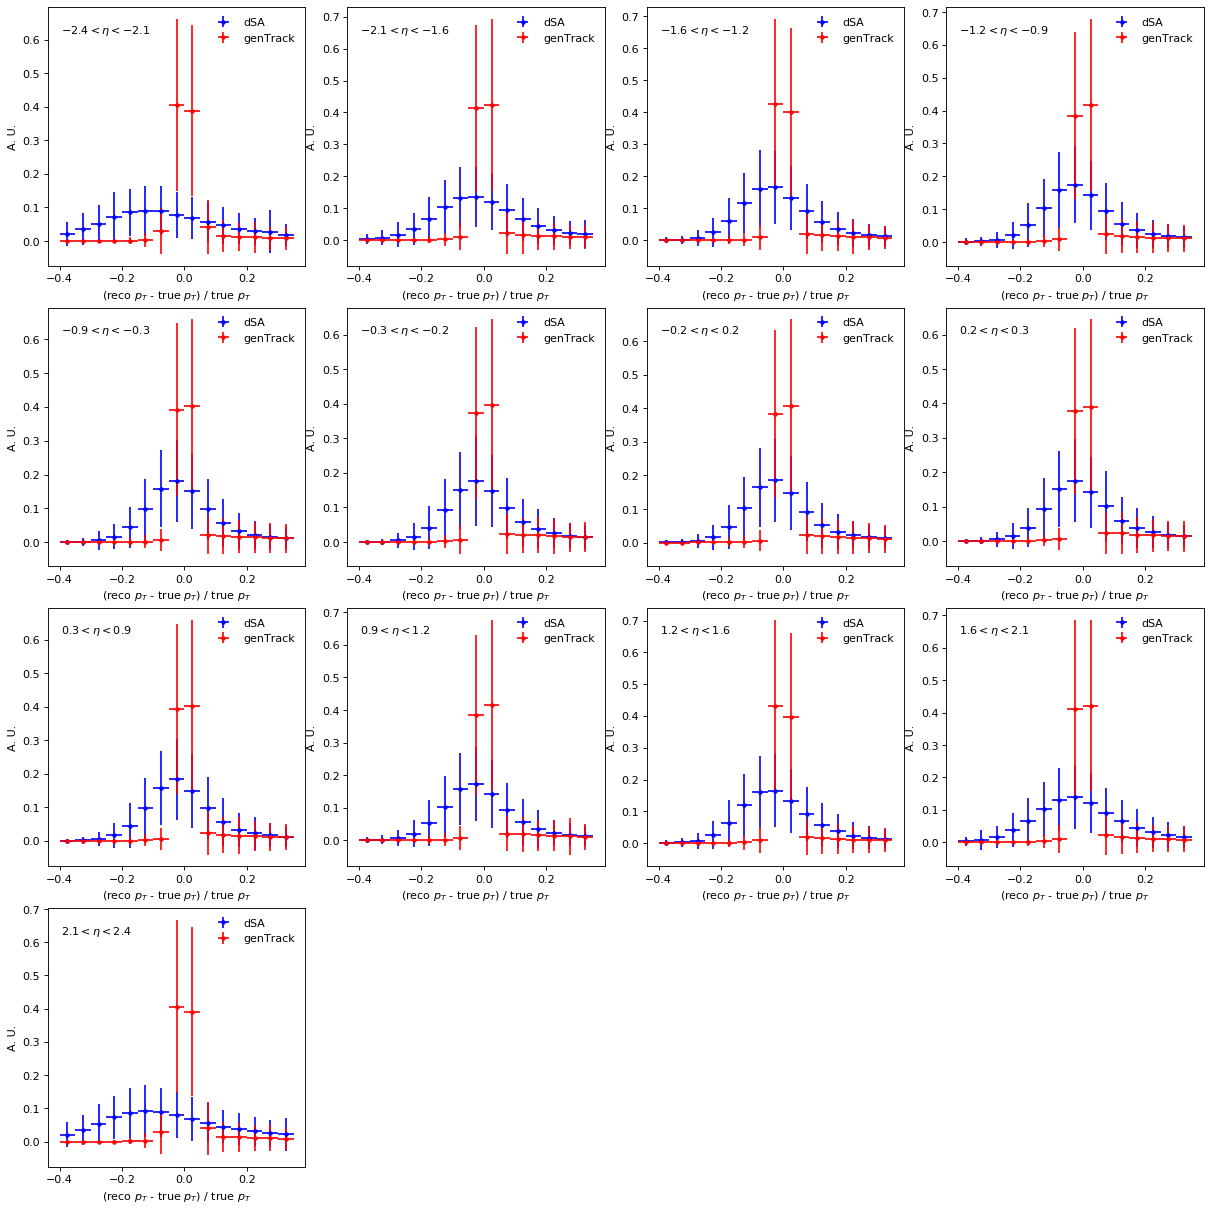

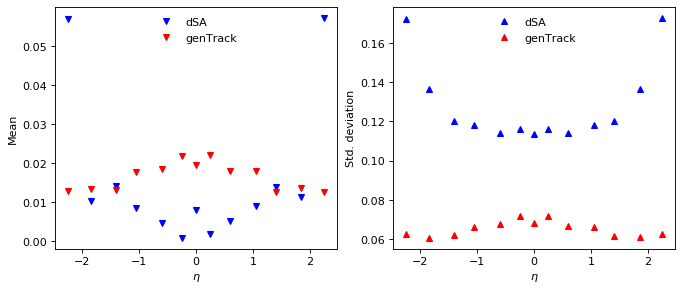

In [205]:
plot_MC_res_vs_eta({'JPsi_pythia8': dfs_gen['JPsi_pythia8']}, np.array(np.arange(-0.4, 0.4, .05)))

The dSA resolution pT resolution is particularly worse at forward etas, and in the far forward region 2.1 < |eta| < 2.4 it also becomes more biased.

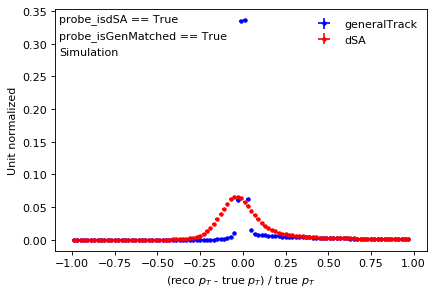

In [125]:
xlabel=r'(reco $p_{T}$ - true $p_{T}$) / true $p_{T}$'

# Get the returned fig and ax objects
fig, ax = plot_MC_res({'JPsi_pythia8': dfs_gen['JPsi_pythia8']}, 'diff_trk_gen_pt', np.array(np.arange(-1, 1, .02)), 
                      label='generalTrack')

# Pass these objects again to plot in the same figure
fig, ax = plot_MC_res({'JPsi_pythia8': dfs_gen['JPsi_pythia8']}, 'diff_dsa_gen_pt', np.array(np.arange(-1, 1, .02)), 
                       fig=fig, ax=ax, style='.r', label='dSA')

ax.legend(frameon=False, loc='upper right')
top_lim = 0.95
ax.text(0.01, top_lim, 'probe_isdSA == True', transform=ax.transAxes)
ax.text(0.01, top_lim - 0.07, 'probe_isGenMatched == True', transform=ax.transAxes)
ax.text(0.01, top_lim - 2*0.07, 'Simulation', transform=ax.transAxes)
ax.set_ylabel('Unit normalized')
ax.set_xlabel(xlabel)
fig.show()

The plot above shows the pT resolution averaged over all etas.

The plot below shows coarser eta splittings to get more stats in each.

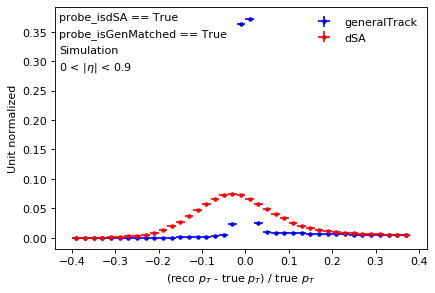

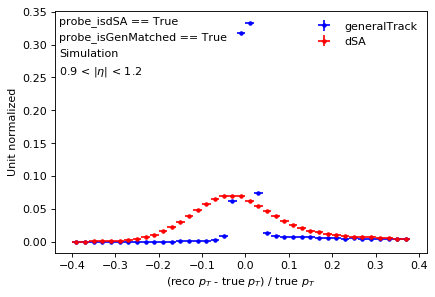

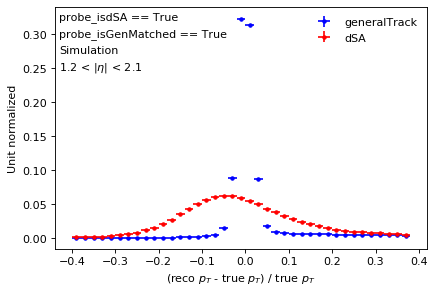

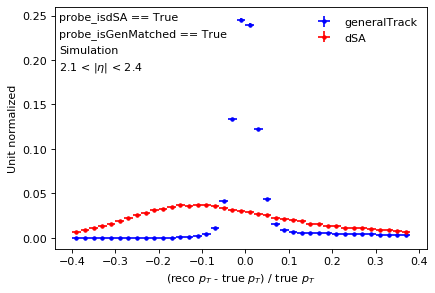

In [19]:
xlabel=r'(reco $p_{T}$ - true $p_{T}$) / true $p_{T}$'

eta_bins = [0, 0.9, 1.2, 2.1, 2.4]

for i in range(len(eta_bins)-1):
    eta_cut = f'probe_abseta > {eta_bins[i]} and probe_abseta < {eta_bins[i+1]}'

    # Get the returned fig and ax objects
    fig, ax = plot_MC_res({'JPsi_pythia8': dfs_gen['JPsi_pythia8'].filter(eta_cut)}, 'diff_trk_gen_pt', 
                           np.array(np.arange(-0.4, 0.4, .02)), 
                           label='generalTrack')

    # Pass these objects again to plot in the same figure
    fig, ax = plot_MC_res({'JPsi_pythia8': dfs_gen['JPsi_pythia8'].filter(eta_cut)}, 'diff_dsa_gen_pt', 
                          np.array(np.arange(-0.4, 0.4, .02)), fig=fig, ax=ax, style='.r', 
                          label='dSA')


    ax.legend(frameon=False, loc='upper right')
    top_lim = 0.95
    ax.text(0.01, top_lim, 'probe_isdSA == True', transform=ax.transAxes)
    ax.text(0.01, top_lim - 0.07, 'probe_isGenMatched == True', transform=ax.transAxes)
    ax.text(0.01, top_lim - 2*0.07, 'Simulation', transform=ax.transAxes)
    ax.text(0.01, top_lim - 3*0.07, f'{eta_bins[i]} < |$\eta$| < {eta_bins[i+1]}', transform=ax.transAxes)
    ax.set_ylabel('Unit normalized')
    ax.set_xlabel(xlabel)
    fig.show()

## Angular resolutions

We also plot the eta resolution...

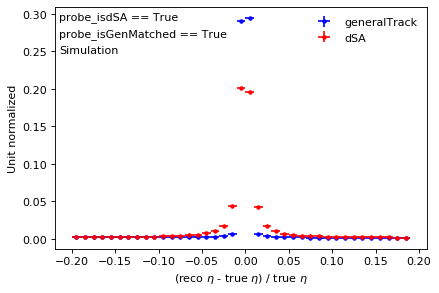

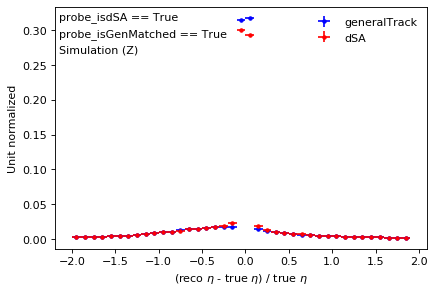

In [22]:
xlabel=r'(reco $\eta$ - true $\eta$) / true $\eta$'
top_lim = 0.95

fig, ax = plot_MC_res({sim_alias: dfs_gen[sim_alias]}, 'diff_trk_gen_eta', np.array(np.arange(-0.2, 0.2, .01)), 
                      label='generalTrack')
fig, ax = plot_MC_res({sim_alias: dfs_dsa[sim_alias]}, 'diff_dsa_gen_eta', np.array(np.arange(-0.2, 0.2, .01)), 
                       fig=fig, ax=ax, style='.r', label='dSA')

ax.legend(frameon=False, loc='upper right')
ax.text(0.01, top_lim, 'probe_isdSA == True', transform=ax.transAxes)
ax.text(0.01, top_lim - 0.07, 'probe_isGenMatched == True', transform=ax.transAxes)
ax.text(0.01, top_lim - 2*0.07, 'Simulation', transform=ax.transAxes)
ax.set_ylabel('Unit normalized')
ax.set_xlabel(xlabel)
fig.show()



fig, ax = plot_MC_res({sim_alias: dfs_gen[sim_alias]}, 'diff_trk_gen_eta', np.array(np.arange(-2, 2, .1)), 
                      label='generalTrack')
fig, ax = plot_MC_res({sim_alias: dfs_dsa[sim_alias]}, 'diff_dsa_gen_eta', np.array(np.arange(-2, 2, .1)), 
                       fig=fig, ax=ax, style='.r', label='dSA')

ax.legend(frameon=False, loc='upper right')
ax.text(0.01, top_lim, 'probe_isdSA == True', transform=ax.transAxes)
ax.text(0.01, top_lim - 0.07, 'probe_isGenMatched == True', transform=ax.transAxes)
ax.text(0.01, top_lim - 2*0.07, f'Simulation ({resonance})', transform=ax.transAxes)
ax.set_ylabel('Unit normalized')
ax.set_xlabel(xlabel)
fig.show()

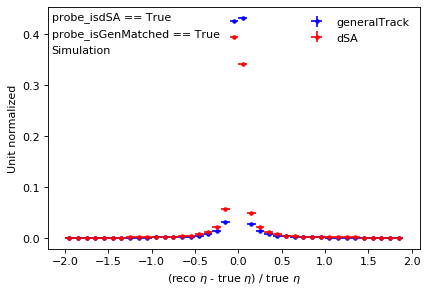

... and the phi resolution.

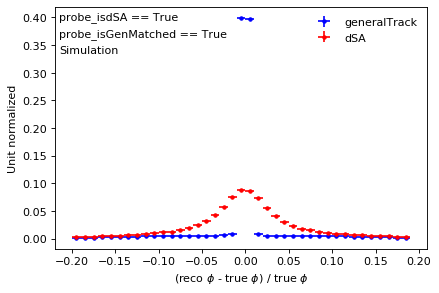

In [10]:
xlabel=r'(reco $\phi$ - true $\phi$) / true $\phi$'
top_lim = 0.95

fig, ax = plot_MC_res({'JPsi_pythia8': dfs_gen['JPsi_pythia8']}, 'diff_trk_gen_phi', np.array(np.arange(-0.2, 0.2, .01)), 
                      label='generalTrack')
fig, ax = plot_MC_res({'JPsi_pythia8': dfs_dsa['JPsi_pythia8']}, 'diff_dsa_gen_phi', np.array(np.arange(-0.2, 0.2, .01)), 
                       fig=fig, ax=ax, style='.r', label='dSA')
ax.legend(frameon=False, loc='upper right')
ax.text(0.01, top_lim, 'probe_isdSA == True', transform=ax.transAxes)
ax.text(0.01, top_lim - 0.07, 'probe_isGenMatched == True', transform=ax.transAxes)
ax.text(0.01, top_lim - 2*0.07, 'Simulation', transform=ax.transAxes)
ax.set_ylabel('Unit normalized')
ax.set_xlabel(xlabel)
fig.show()



fig, ax = plot_MC_res({'JPsi_pythia8': dfs_gen['JPsi_pythia8']}, 'diff_trk_gen_phi', np.array(np.arange(-3, 3, .1)), 
                      label='generalTrack')
fig, ax = plot_MC_res({'JPsi_pythia8': dfs_dsa['JPsi_pythia8']}, 'diff_dsa_gen_phi', np.array(np.arange(-3, 3, .1)), 
                       fig=fig, ax=ax, style='.r', label='dSA')
ax.legend(frameon=False, loc='upper right')
ax.text(0.01, top_lim, 'probe_isdSA == True', transform=ax.transAxes)
ax.text(0.01, top_lim - 0.07, 'probe_isGenMatched == True', transform=ax.transAxes)
ax.text(0.01, top_lim - 2*0.07, 'Simulation', transform=ax.transAxes)
ax.set_ylabel('Unit normalized')
ax.set_xlabel(xlabel)
fig.show()

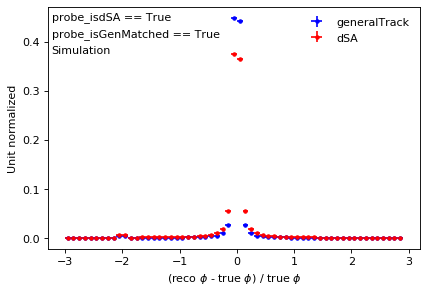

And then then the dR(reco, gen) using Z.

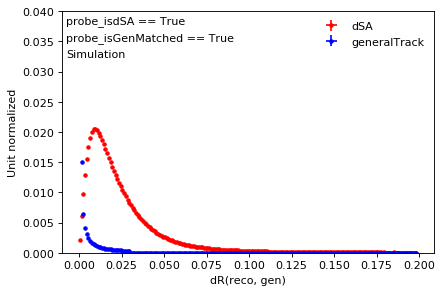

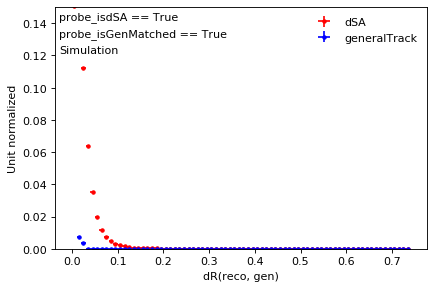

In [16]:
xlabel=r'dR(reco, gen)'

fig, ax = plot_MC_res({'DY_madgraph': dfs_dsa['DY_madgraph']}, 'diff_dsa_gen_dr', np.array(np.arange(0.0, 0.2, .001)), 
                       style='.r', label='dSA')
fig, ax = plot_MC_res({'DY_madgraph': dfs_gen['DY_madgraph']}, 'diff_trk_gen_dr', np.array(np.arange(0.0, 0.2, .001)), 
                       fig=fig, ax=ax, style='.b', label='generalTrack')
ax.legend(frameon=False, loc='upper right')
top_lim = 0.95
ax.text(0.01, top_lim, 'probe_isdSA == True', transform=ax.transAxes)
ax.text(0.01, top_lim - 0.07, 'probe_isGenMatched == True', transform=ax.transAxes)
ax.text(0.01, top_lim - 2*0.07, 'Simulation', transform=ax.transAxes)
ax.set_ylabel('Unit normalized')
# ax.set_yscale('log')
ax.set_ylim(0, 0.04)
ax.set_xlabel(xlabel)
fig.show()

xlabel=r'dR(reco, gen)'

fig, ax = plot_MC_res({'DY_madgraph': dfs_gen['DY_madgraph']}, 'diff_dsa_gen_dr', np.array(np.arange(0.0, 0.75, .01)), 
                       style='.r', label='dSA')
fig, ax = plot_MC_res({'DY_madgraph': dfs_gen['DY_madgraph']}, 'diff_trk_gen_dr', np.array(np.arange(0.0, 0.75, .01)), 
                       fig=fig, ax=ax, style='.b', label='generalTrack')
ax.legend(frameon=False, loc='upper right')
top_lim = 0.95
ax.text(0.01, top_lim, 'probe_isdSA == True', transform=ax.transAxes)
ax.text(0.01, top_lim - 0.07, 'probe_isGenMatched == True', transform=ax.transAxes)
ax.text(0.01, top_lim - 2*0.07, 'Simulation', transform=ax.transAxes)
ax.set_ylabel('Unit normalized')
# ax.set_yscale('log')
ax.set_ylim(0, 0.15)
ax.set_xlabel(xlabel)
fig.show()

The dR(reco, gen) seems to fade around 0.1, so using a 0.2 threshold is sufficient when performing the matching.

Equivalent plots of dR(reco, gen) using J/Psi.

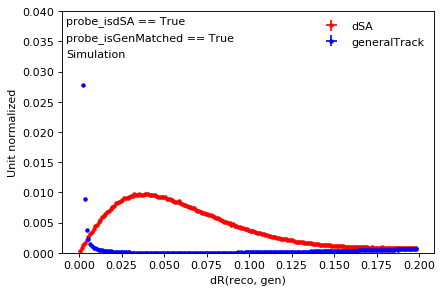

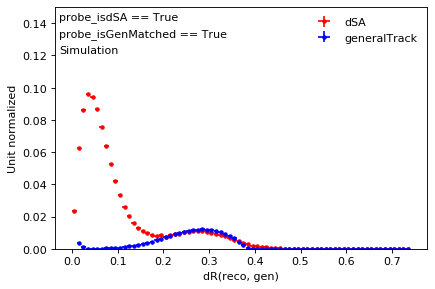

In [29]:
xlabel=r'dR(reco, gen)'
top_lim = 0.95

filter_gen = 'gen_pair_dR > 0.3'
filter_reco = 'pair_dR > 0.05'

fig, ax = plot_MC_res({'JPsi_pythia8': dfs_gen['JPsi_pythia8'].filter(filter_reco)}, 'diff_dsa_gen_dr', np.array(np.arange(0.0, 0.2, .001)), 
                       style='.r', label='dSA')
fig, ax = plot_MC_res({'JPsi_pythia8': dfs_gen['JPsi_pythia8'].filter(filter_reco)}, 'diff_trk_gen_dr', np.array(np.arange(0.0, 0.2, .001)), 
                       fig=fig, ax=ax, style='.b', label='generalTrack')
ax.legend(frameon=False, loc='upper right')
ax.text(0.01, top_lim, 'probe_isdSA == True', transform=ax.transAxes)
ax.text(0.01, top_lim - 0.07, 'probe_isGenMatched == True', transform=ax.transAxes)
ax.text(0.01, top_lim - 2*0.07, 'Simulation', transform=ax.transAxes)
ax.set_ylabel('Unit normalized')
# ax.set_yscale('log')
ax.set_ylim(0, 0.04)
ax.set_xlabel(xlabel)
fig.show()


fig, ax = plot_MC_res({'JPsi_pythia8': dfs_gen['JPsi_pythia8'].filter(filter_reco)}, 'diff_dsa_gen_dr', np.array(np.arange(0.0, 0.75, .01)), 
                       style='.r', label='dSA')
fig, ax = plot_MC_res({'JPsi_pythia8': dfs_gen['JPsi_pythia8'].filter(filter_reco)}, 'diff_trk_gen_dr', np.array(np.arange(0.0, 0.75, .01)), 
                       fig=fig, ax=ax, style='.b', label='generalTrack')
ax.legend(frameon=False, loc='upper right')
ax.text(0.01, top_lim, 'probe_isdSA == True', transform=ax.transAxes)
ax.text(0.01, top_lim - 0.07, 'probe_isGenMatched == True', transform=ax.transAxes)
ax.text(0.01, top_lim - 2*0.07, 'Simulation', transform=ax.transAxes)
ax.set_ylabel('Unit normalized')
# ax.set_yscale('log')
ax.set_ylim(0, 0.15)
ax.set_xlabel(xlabel)
fig.show()

Also plot dphi and deta.

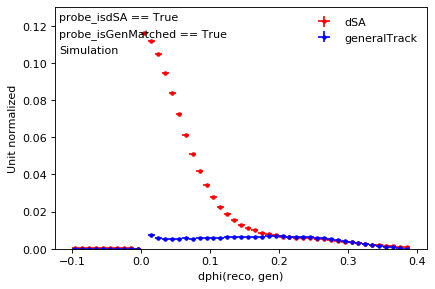

In [82]:
xlabel=r'dphi(reco, gen)'

fig, ax = plot_MC_res({'JPsi_pythia8': dfs_gen['JPsi_pythia8']}, 'dsa_gen_reduced_dphi', np.array(np.arange(-0.1, 0.4, .01)), 
                       style='.r', label='dSA')
fig, ax = plot_MC_res({'JPsi_pythia8': dfs_gen['JPsi_pythia8']}, 'trk_gen_reduced_dphi', np.array(np.arange(-0.1, 0.4, .01)), 
                       fig=fig, ax=ax, style='.b', label='generalTrack')
ax.legend(frameon=False, loc='upper right')
top_lim = 0.95
ax.text(0.01, top_lim, 'probe_isdSA == True', transform=ax.transAxes)
ax.text(0.01, top_lim - 0.07, 'probe_isGenMatched == True', transform=ax.transAxes)
ax.text(0.01, top_lim - 2*0.07, 'Simulation', transform=ax.transAxes)
ax.set_ylabel('Unit normalized')
# ax.set_yscale('log')
ax.set_ylim(0, 0.13)
ax.set_xlabel(xlabel)
fig.show()

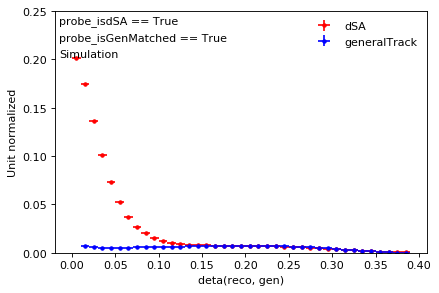

In [83]:
xlabel=r'deta(reco, gen)'

fig, ax = plot_MC_res({'Jpsi': dfs_gen['Jpsi']}, 'dsa_gen_deta', np.array(np.arange(0, 0.4, .01)), 
                       style='.r', label='dSA')
fig, ax = plot_MC_res({'Jpsi': dfs_gen['Jpsi']}, 'trk_gen_deta', np.array(np.arange(0, 0.4, .01)), 
                       fig=fig, ax=ax, style='.b', label='generalTrack')
ax.legend(frameon=False, loc='upper right')
top_lim = 0.95
ax.text(0.01, top_lim, 'probe_isdSA == True', transform=ax.transAxes)
ax.text(0.01, top_lim - 0.07, 'probe_isGenMatched == True', transform=ax.transAxes)
ax.text(0.01, top_lim - 2*0.07, 'Simulation', transform=ax.transAxes)
ax.set_ylabel('Unit normalized')
# ax.set_yscale('log')
ax.set_ylim(0, 0.25)
ax.set_xlabel(xlabel)
fig.show()

There is a 'bump' the dR(reco, gen) distribution arising from J/Psi, which is absent in the Z plot. This might be due to wrong muon assignments and needs to be understood.

## Distributions of N_muon_hits and track_chi2

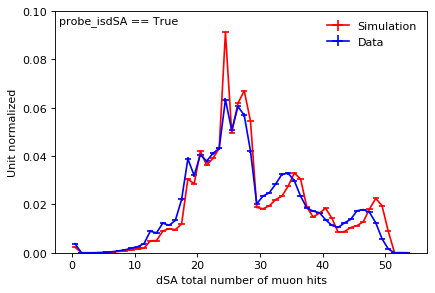

In [100]:
xlabel=r'dSA total number of muon hits'

fig, ax = plot_MC_res({'Jpsi': dfs_dsa['Jpsi']}, 'probe_dsa_muonHits', np.array(np.arange(0, 55, 1)), 
                       style='r', label='Simulation')
fig, ax = plot_MC_res({'Jpsi': dfs_dsa['Run2018A']}, 'probe_dsa_muonHits', np.array(np.arange(0, 55, 1)), 
                       fig=fig, ax=ax, style='b', label='Data')
ax.legend(frameon=False, loc='upper right')
top_lim = 0.95
ax.text(0.01, top_lim, 'probe_isdSA == True', transform=ax.transAxes)
# ax.text(0.01, top_lim - 0.07, 'Simulation', transform=ax.transAxes)
ax.set_ylabel('Unit normalized')
# ax.set_yscale('log')
ax.set_ylim(0, 0.1)
ax.set_xlabel(xlabel)
fig.show()

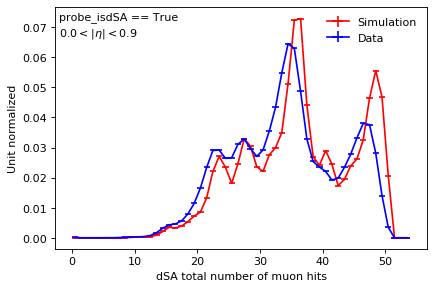

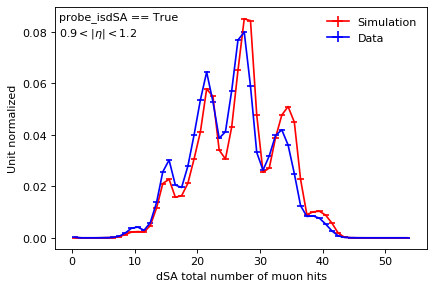

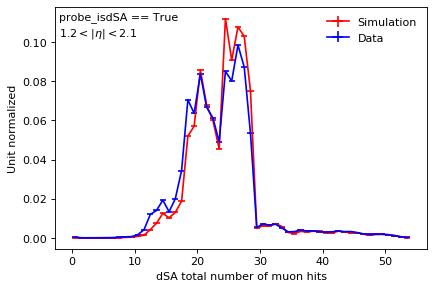

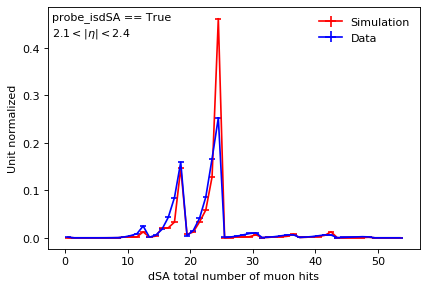

In [24]:
xlabel=r'dSA total number of muon hits'

etas_lo = [0.0, 0.9, 1.2, 2.1]
etas_hi = [0.9, 1.2, 2.1, 2.4]

for eta_lo, eta_hi in zip(etas_lo, etas_hi):

    fig, ax = plot_MC_res({sim_alias: dfs_dsa[sim_alias].filter(f'probe_abseta > {eta_lo} and probe_abseta < {eta_hi}')}, 'probe_dsa_muonHits', np.array(np.arange(0, 55, 1)), 
                           style='r', label='Simulation')
    fig, ax = plot_MC_res({sim_alias: dfs_dsa['Run2018A'].filter(f'probe_abseta > {eta_lo} and probe_abseta < {eta_hi}')}, 'probe_dsa_muonHits', np.array(np.arange(0, 55, 1)), 
                           fig=fig, ax=ax, style='b', label='Data')
    ax.legend(frameon=False, loc='upper right')
    top_lim = 0.95
    ax.text(0.01, top_lim, 'probe_isdSA == True', transform=ax.transAxes)
    # ax.text(0.01, top_lim - 0.07, 'Simulation', transform=ax.transAxes)
    ax.set_ylabel('Unit normalized')
    ax.text(0.01, top_lim - 0.07, f'${eta_lo} < |\eta| < {eta_hi}$', transform=ax.transAxes) #.format(low=eta_lo,high=eta_hi)
    # ax.set_yscale('log')
    # ax.set_ylim(0, 0.1)
    ax.set_xlabel(xlabel)
    fig.show()

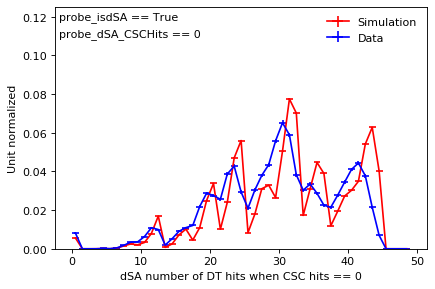

In [101]:
xlabel=r'dSA number of DT hits when CSC hits == 0'

fig, ax = plot_MC_res({'Jpsi': dfs_dsa['Jpsi'].filter('probe_dsa_CSCHits==0')}, 'probe_dsa_DTHits', np.array(np.arange(0, 50, 1)), 
                       style='r', label='Simulation')
fig, ax = plot_MC_res({'Jpsi': dfs_dsa['Run2018A'].filter('probe_dsa_CSCHits==0')}, 'probe_dsa_DTHits', np.array(np.arange(0, 50, 1)), 
                       fig=fig, ax=ax, style='b', label='Data')
ax.legend(frameon=False, loc='upper right')
top_lim = 0.95
ax.text(0.01, top_lim, 'probe_isdSA == True', transform=ax.transAxes)
ax.text(0.01, top_lim - 0.07, 'probe_dSA_CSCHits == 0', transform=ax.transAxes)
ax.set_ylabel('Unit normalized')
# ax.set_yscale('log')
ax.set_ylim(0, 0.125)
ax.set_xlabel(xlabel)
fig.show()

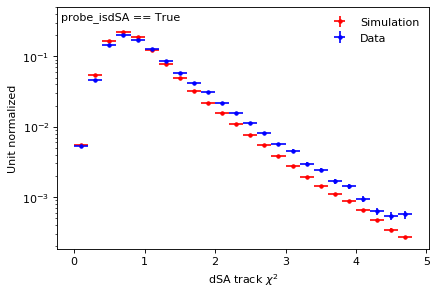

In [99]:
xlabel=r'dSA track $\chi^{2}$'

fig, ax = plot_MC_res({'Jpsi': dfs_dsa['Jpsi']}, 'probe_dsa_trkChi2', np.array(np.arange(0, 5, .2)), 
                       style='.r', label='Simulation')
fig, ax = plot_MC_res({'Jpsi': dfs_dsa['Run2018A']}, 'probe_dsa_trkChi2', np.array(np.arange(0, 5, .2)), 
                       fig=fig, ax=ax, style='.b', label='Data')
ax.legend(frameon=False, loc='upper right')
top_lim = 0.95
ax.text(0.01, top_lim, 'probe_isdSA == True', transform=ax.transAxes)
# ax.text(0.01, top_lim - 0.07, 'Simulation', transform=ax.transAxes)
ax.set_ylabel('Unit normalized')
ax.set_yscale('log')
ax.set_ylim(top=0.5)
ax.set_xlabel(xlabel)
fig.show()

There is disagreement between MC and data in the number of hits in the barrel region, but not so much in the forward region. This is well understood to be caused by mismodelings int the local hit reconstruction of the DT chambers. It's possible that the discrepancy in N_hits and the dSA track chi2 are correlated, the former causing the latter.